In [1]:
%matplotlib inline

In [25]:
import cv2
import os
import math
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)
from tensorflow.keras.optimizers import Adam,SGD
from imblearn.over_sampling import SMOTE
from collections import Counter
from model_maker import make_model,evaluate_model

In [26]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

In [39]:
#Load all patients 
my_data = pd.read_csv('../data/Fifteen_Frames_Per_patient.csv')
patients_data=pd.read_csv('../data/videos_data.csv')
data_array = my_data.to_numpy()
patients_array=patients_data["FileName"].to_numpy()
images_path = '../data/Fifteen_Frames_Per_patient/'
no_of_test_patients=math.floor(patients_array.size*0.2) 
images_data = []
models = []

df=my_data
data_array=df.to_numpy()
for i in data_array:
    img = cv2.imread(images_path + i[0] + '.' + i[2], cv2.IMREAD_GRAYSCALE)
    img=  cv2.equalizeHist(img)
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img_2d = img.reshape(IMAGE_WIDTH ,IMAGE_HEIGHT,1)
    images_data.append(img_2d)

X=np.asarray(images_data)
y = np.asarray(my_data['Label'])
print(Counter(y))

Counter({'regular': 840, 'pneumonia': 540, 'covid': 450})


In [40]:
testPatient_indexes= [1,2,12,14,15,22,
                      33,34,37,42,43,52,53,
                      92,95,96,99,101,102,104,107,110,115,118]


In [41]:
#getting frame indexes of each patient
frames_index=[]
for i in testPatient_indexes:
  j=i*15
  z=j+15
  while j<z:
    frames_index.append(j)
    j+=1

# Adding the frames to X_test
X_test=np.take(X,frames_index,axis=0)
y_test=np.take(y,frames_index,axis=0)
# Removing the frames from X_train
X_train=np.delete(X,frames_index,axis=0)
y_train=np.delete(y,frames_index,axis=0)

# Scale the pixels
X_train=X_train/255.0
X_test=X_test/255.0

In [42]:
#Applying SMOTE
oversample = SMOTE()
X_train=np.resize(X_train,(X_train.shape[0],50176))
X_train,y_train=oversample.fit_resample(X_train, y_train)
X_train=np.resize(X_train,(X_train.shape[0],224,224,1))
counter=Counter(y_train)
print(counter)
y_fold=y_train
#Label encode classes to numbers
#One-hot Encode y
number = preprocessing.LabelEncoder()
y_train=number.fit_transform(y_train)
y_train=to_categorical(y_train,3)

number2 = preprocessing.LabelEncoder()
y_test=number2.fit_transform(y_test)
y_test=to_categorical(y_test,3)

Counter({'covid': 675, 'pneumonia': 675, 'regular': 675})


In [31]:
print('X_train: '+str(X_train.shape))
print('y_train: '+str(y_train.shape))
print('X_test: '+ str(X_test.shape))
print('y_test: '+ str(y_test.shape))

X_train: (2025, 224, 224, 1)
y_train: (2025, 3)
X_test: (360, 224, 224, 1)
y_test: (360, 3)


In [32]:
# initialize the training data augmentation object
MODEL_PATH=os.path.join('', "Conv2d-SMOT 15 Frames")

trainAug = ImageDataGenerator(
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

mcp_save = ModelCheckpoint(
    MODEL_PATH,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [33]:
BATCH_SIZE=16
EPOCHS=20
LR=1e-4
opt = Adam(learning_rate=LR,decay=LR / 20)
# Define callbacks
earlyStopping = EarlyStopping(
    monitor='loss',
    patience=20,
    verbose=1,
    mode='min',
    restore_best_weights=True
)


reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=7,
    verbose=1,
    min_delta=1e-4,
    mode='min'
)

In [34]:
model=make_model()
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history=model.fit(
    trainAug.flow(X_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/20
126/126 [==============================] - 10s 72ms/step - loss: 0.9349 - accuracy: 0.5361 - val_loss: 1.0103 - val_accuracy: 0.5889

Epoch 00001: val_accuracy improved from -inf to 0.58889, saving model to Conv2d-SMOT 15 Frames
INFO:tensorflow:Assets written to: Conv2d-SMOT 15 Frames\assets
Epoch 2/20
126/126 [==============================] - 9s 73ms/step - loss: 0.5923 - accuracy: 0.7586 - val_loss: 0.7377 - val_accuracy: 0.6944

Epoch 00002: val_accuracy improved from 0.58889 to 0.69444, saving model to Conv2d-SMOT 15 Frames
INFO:tensorflow:Assets written to: Conv2d-SMOT 15 Frames\assets
Epoch 3/20
126/126 [==============================] - 9s 74ms/step - loss: 0.4196 - accuracy: 0.8377 - val_loss: 0.6719 - val_accuracy: 0.7750

Epoch 00003: val_accuracy improved from 0.69444 to 0.77500, saving model to Conv2d-SMOT 15 Frames
INFO:tensorflow:Assets written to: Conv2d-SMOT 15 Frames\assets
Epoch 4/20
126/126 [==============================] - 9s 72ms/step - loss: 0.3578 - 

Train: 0.988, Test: 0.825


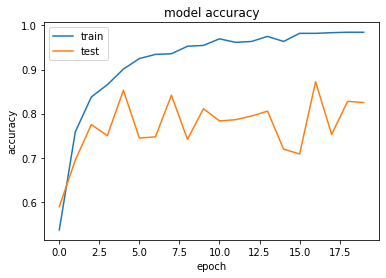

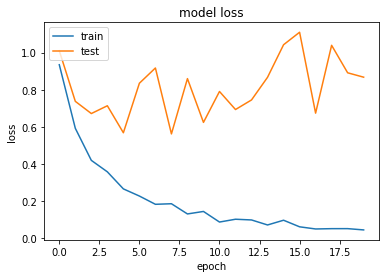

              precision    recall  f1-score   support

       Covid       1.00      0.61      0.76        90
   Pneumonia       0.78      0.99      0.87       105
     Healthy       0.81      0.84      0.83       165

    accuracy                           0.83       360
   macro avg       0.86      0.81      0.82       360
weighted avg       0.85      0.83      0.82       360

[[ 55   4  31]
 [  0 104   1]
 [  0  26 139]]


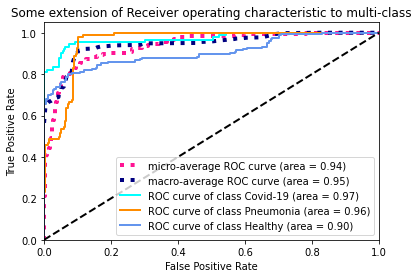

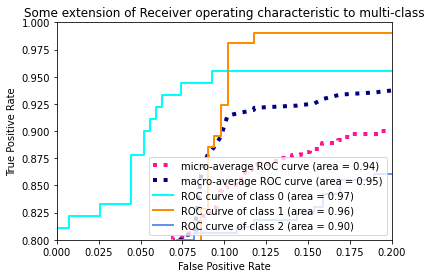

In [36]:
evaluate_model(model,history,X_train,y_train,X_test,y_test)

In [37]:
from mostCommon import most_common,patient_score
y_pred=model.predict(X_test)
prediction = np.argmax(y_pred, axis=1)
real=np.argmax(y_test, axis=1)
patient_score(real,prediction)

[[4 0 2]
 [0 7 0]
 [0 2 9]]
              precision    recall  f1-score   support

           0      1.000     0.667     0.800         6
           1      0.778     1.000     0.875         7
           2      0.818     0.818     0.818        11

    accuracy                          0.833        24
   macro avg      0.865     0.828     0.831        24
weighted avg      0.852     0.833     0.830        24



In [43]:
# MLP for Pima Indians Dataset with 10-fold cross validation
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold


# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=False)
cvscores = []
for train, test in kfold.split(X_train, y_fold):
  # create model
    model=make_model()
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    print('hi')
    model.fit(X_train[train], y_train[train], epochs=15, batch_size=30, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

hi
accuracy: 82.22%
hi
accuracy: 88.64%
hi
accuracy: 74.07%
hi
accuracy: 97.28%
hi
accuracy: 96.05%
87.65% (+/- 8.70%)
